In [1]:
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9 as cosmo
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.optimize import curve_fit, brentq

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]
# Calculate the fraction of data that remains
fraction_remaining = len(k_gg) / len(k['k_gg'])
print(f"Fraction of data that remained: {fraction_remaining:.2f}")

Fraction of data that remained: 1.00


In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]
TARGETID = d['TARGETID'][SEL][~indice]
d_desi = Planck18.distmod(z_desi).value
volume = cosmo.comoving_volume(z_desi).value

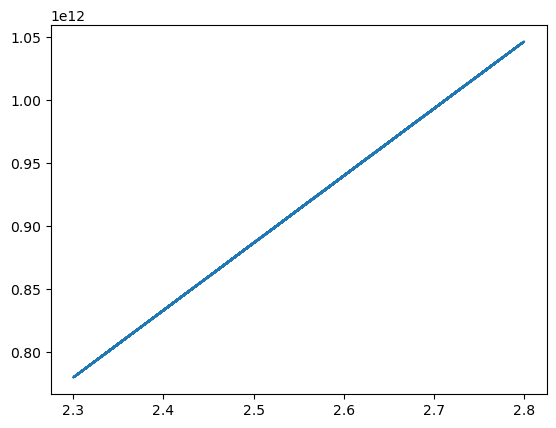

In [4]:
plt.plot(z_desi,volume)

In [5]:
print(cosmo.comoving_volume(np.array([2.1,2.2,2.3,2.4])).value)

[6.73282192e+11 7.26267986e+11 7.79531487e+11 8.32962198e+11]


In [6]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
apr_mag_g = apr_mag_g[indices]
apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [7]:
print(TARGETID.shape)

(157741,)


In [8]:
mag_r_bins = np.linspace(np.min(apr_mag_r), np.max(apr_mag_r), 30)
z_bins = np.linspace(np.min(z_desi), np.max(z_desi), 10)
counts_r,z_edges,mag_r_edges= np.histogram2d(z_desi, apr_mag_r, bins=[z_bins, mag_r_bins])

In [9]:
mag_r_bin_widths = np.diff(mag_r_bins)[0]  # Differences between consecutive bin edges for magnitude
z_bin_widths = np.diff(z_bins)[0]          # Differences between consecutive bin edges for redshift

In [10]:
def comoving_volume(z1,z2):
    """
    Calculate the comoving volume between two redshifts.
    
    Args:
        z1 (float): Lower redshift bound
        z2 (float): Upper redshift bound
    
    Returns:
        float: Comoving volume in cubic megaparsecs (Mpc^3)
    """
    #d1 = cosmo.comoving_distance(z1).value# Mpc
    #d2 = cosmo.comoving_distance(z2).value# Mpc
    return cosmo.comoving_volume(z2).value-cosmo.comoving_volume(z1).value

In [11]:
comoving_volume(2.3,2.8)

267065024978.4026

In [12]:
phi_r = np.zeros_like(counts_r)
volumes = np.array([comoving_volume(z_edges[i], z_edges[i+1]) for i in range(len(z_edges)-1)]) 
delta_m_r = np.diff(mag_r_bins)
x=0
for i in range(len(z_bins)-1):
    for j in range(len(mag_r_bins)-1):
        phi_r[i, j] = counts_r[i, j] / (volumes[i] * delta_m_r[j])/0.16
        #print(phi_r[i,j],counts_r[i,j],volumes[i],delta_m_r[j])
#print(phi_r.shape,x)

In [29]:
def phi1(m,z1, z2):
   # indices = np.where((z_desi > z1) & (z_desi < z2))
   # k_mean = np.mean(k_rr[indices])
    new_z = (z1+z2)/2
    new_d = Planck18.distmod(new_z).value
    L = abs_mag_to_L(m - new_d - 1.8)
   # L = abs_mag_to_L(m - k_mean - new_d-2.85)
    #print(L)
    phi1 = 0.4*get_phis(L,new_z,"shen20")
    return phi1

In [30]:
phi_r_prediction = np.zeros((len(z_bins)-1, len(mag_r_bins)-1))

for i in range(len(z_bins)-1):    
    for j in range(len(mag_r_bins)-1):
        m_mid = 0.5 * (mag_r_bins[j] + mag_r_bins[j+1])
        phi_r_prediction[i,j] = phi1(m_mid,z_bins[i],z_bins[i+1])

1.0 12.857558363200463 18.964416604342016


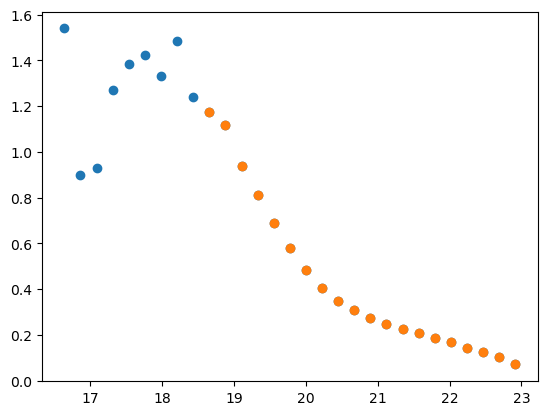

In [31]:
# Define the function with two parameters
def func(x, a, b,m0):
    return (x/m0)**(-b)

# Calculate the central values of the bins
mag_r_cens = 0.5 * (mag_r_bins[1:] + mag_r_bins[:-1])

# Calculate the ratio
ratio = np.mean(phi_r / phi_r_prediction, axis=0)

# Plot the initial scatter plot
plt.scatter(mag_r_cens, ratio)

# Apply a filter to select the desired indices
indices = (mag_r_cens > 18.615866235231778) 
plt.scatter(mag_r_cens[indices], ratio[indices])

# Fit the curve to the filtered data
popt, pcov = curve_fit(func, mag_r_cens[indices], ratio[indices], maxfev=24000)

# Unpack the fitted parameters
a, b, m0= popt
print(a, b, m0)

#plt.plot(x_fit, y_fit, label='Fitted Function', color='red')

In [32]:
print(mag_r_cens.max())

22.915232263762377


In [33]:
def equation_to_solve(x):
    return func(x, a, b, c, d, e) - 1
x_min = 18  # start a bit above zero to avoid division by zero
x_max = 24

try:
    x_solution = brentq(equation_to_solve, x_min, x_max)
    print(f"The value of x that makes y = 1 is approximately: {x_solution}")
except ValueError as e:
    print(f"Root-finding algorithm did not converge: {e}")

# Plot the original data points
plt.scatter(mag_r_cens[indices], ratio[indices], label='Data Points')

# Plot the fitted function
x_fit = np.linspace(mag_r_cens[indices].min(), mag_r_cens[indices].max(), 100)
y_fit = func(x_fit, *popt)
plt.plot(x_fit, y_fit, label='Fitted Function', color='red')

# Highlight the solution point if found
if 'x_solution' in locals():
    plt.scatter([x_solution], [1], color='green', zorder=5, label='y = 1 Solution')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Fitting with Negative Powers from -1 to -5')
plt.show()

NameError: name 'c' is not defined

In [34]:
print(ratio[mag_r_cens<18.538539817149537].mean())

1.2780632282434767


In [35]:
x_fit = np.linspace(mag_r_cens.min(), mag_r_cens.max(), 100)
y_fit = func(x_fit, *popt)
a, b ,c,d,e= popt
plt.scatter(mag_r_cens[indices],ratio[indices])
plt.plot(x_fit, y_fit, label='Fitted Function', color='red')

ValueError: not enough values to unpack (expected 5, got 3)

In [36]:
def efficiency(x, m0= , a, b):
    eff = jnp.where(x < m0, 1, a * ((x - m0) / 20 + a**(1/b))**(-b))
    return eff

SyntaxError: invalid syntax (2839642493.py, line 1)

In [37]:
x_fit = np.linspace(mag_r_cens.min(), mag_r_cens.max() , 100)
y_fit = efficiency(x_fit)
plt.scatter(mag_r_cens, ratio, label='Data')
plt.plot(x_fit, y_fit, label='Selection function', color='red')
plt.xlabel('Magnitude')
plt.ylabel('Ratio')
plt.legend()
plt.title('Selection Function vs Magnitude')

NameError: name 'efficiency' is not defined

/tmp/ipykernel_829246/2105292347.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(mag_r_cens, np.log10(phi_r[i,:]),label='DESI')


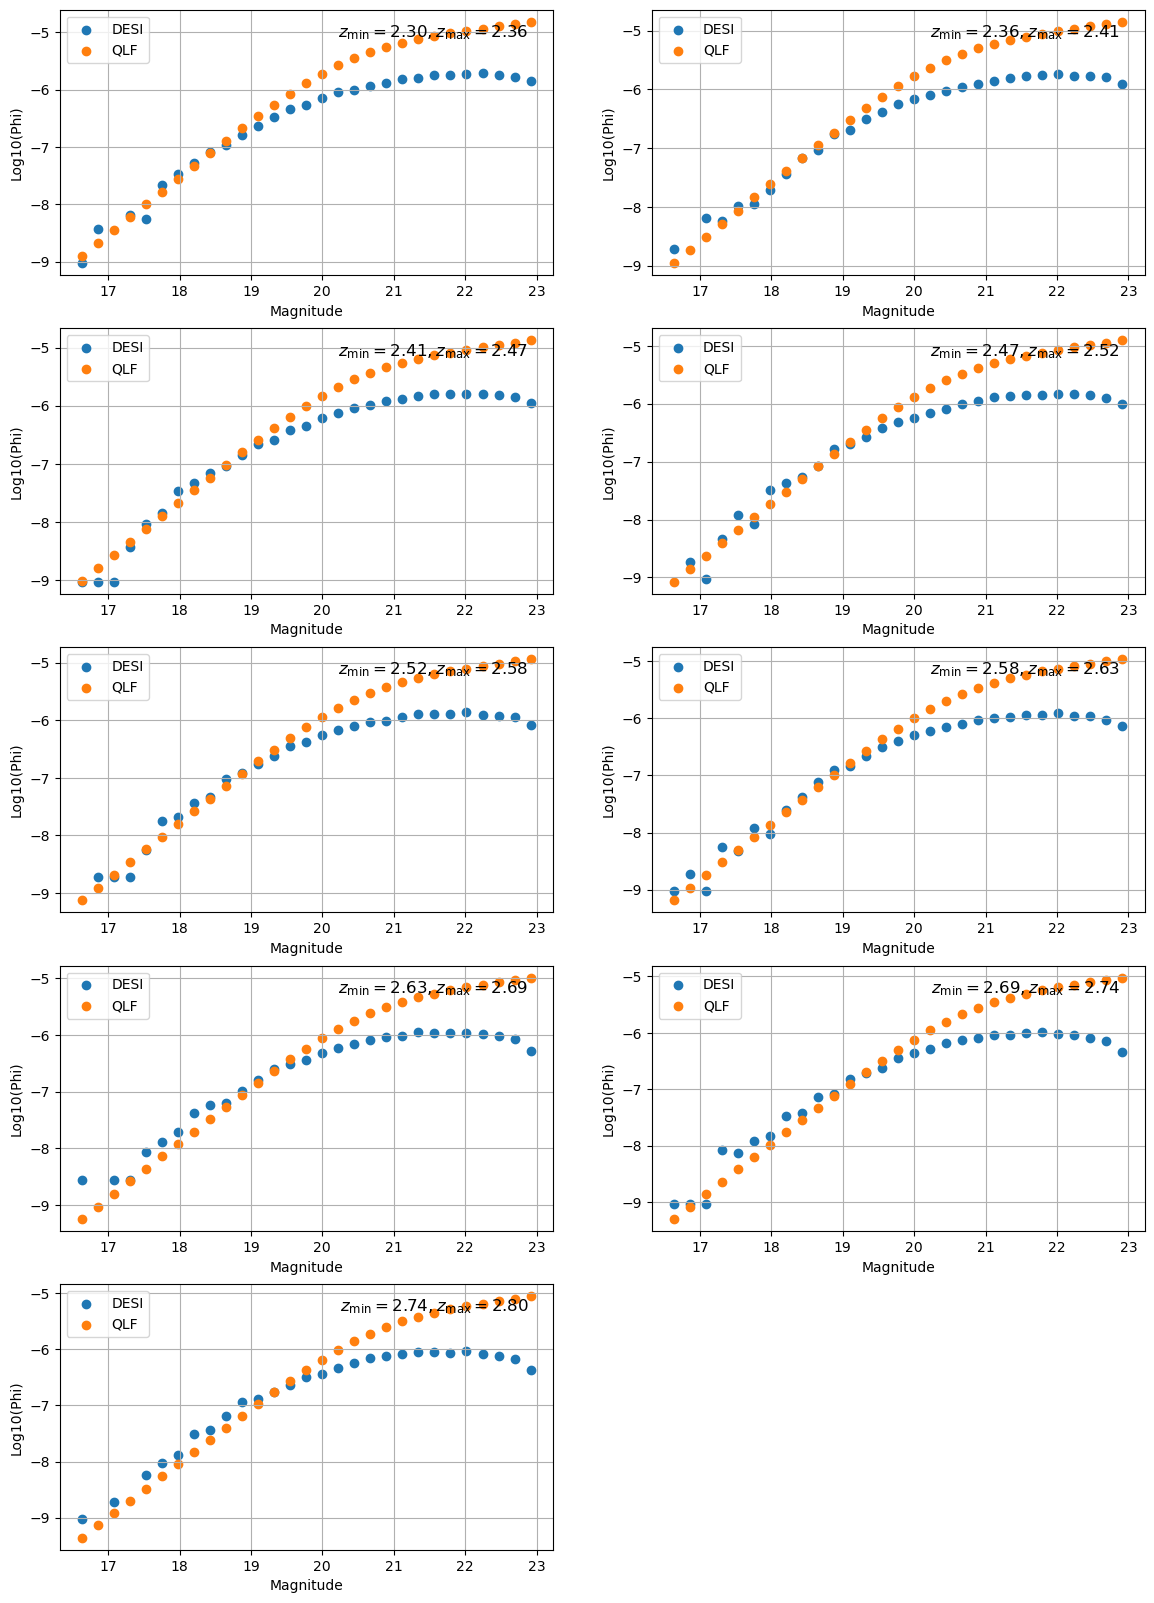

In [38]:
from matplotlib import gridspec
fig = plt.figure(figsize=(14, 20))
gs = gridspec.GridSpec(5, 2, hspace=0.2, wspace=0.2)

for i in range(0,9):
    mag_r_cens = 0.5*(mag_r_bins[1:]+mag_r_bins[:-1])
    ax = plt.subplot(gs[i])
    ax.scatter(mag_r_cens, np.log10(phi_r[i,:]),label='DESI')
    ax.scatter(mag_r_cens,np.log10(phi_r_prediction[i,:]),label='QLF')
    ax.grid()
    ax.set_xlabel('Magnitude')  # Label for the x-axis
    ax.set_ylabel('Log10(Phi)')  # Label for the y-axis
    #ax.set_xlim([-32, -25])  # Adjust x-axis limits
    #ax.set_ylim([-9, -4])
    ax.legend(loc='upper left')
    ax.text(0.95, 0.95, f'$z_{{\min}} = {z_bins[i]:.2f}, z_{{\max}} = {z_bins[i+1]:.2f}$', fontsize=12, ha='right', va='top', transform=ax.transAxes)
plt.show()

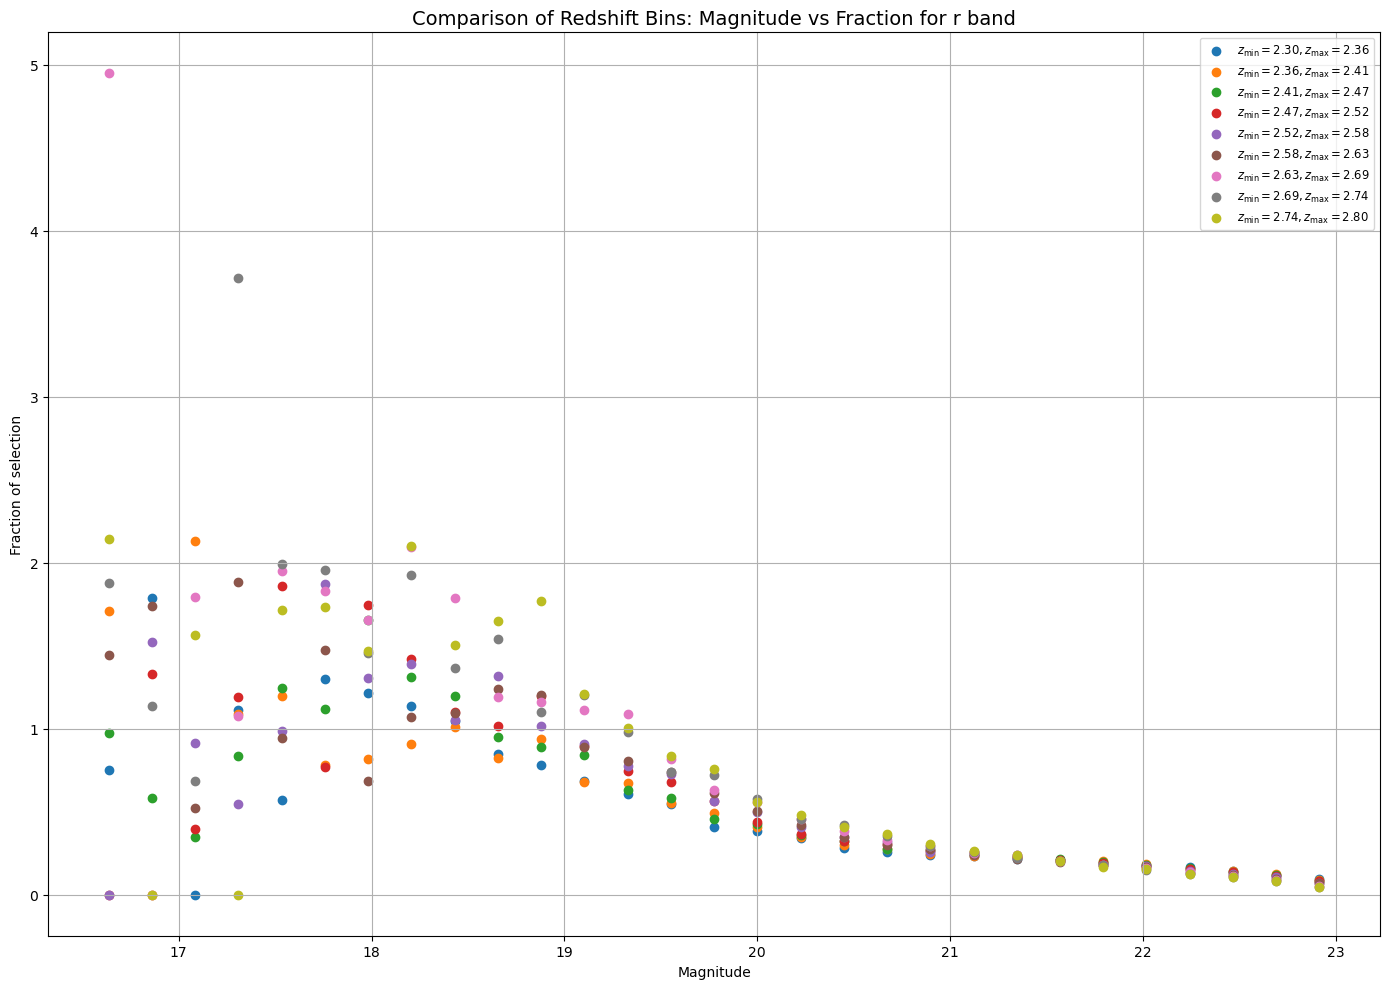

In [39]:
from matplotlib import gridspec

# Create a figure with a single set of axes
fig, ax = plt.subplots(figsize=(14, 10))

mag_r_cens = 0.5 * (mag_r_bins[1:] + mag_r_bins[:-1])

# Plot each dataset on the same axes
for i in range(9):  # Adjust to 10 if there are 10 bins
    ax.scatter(mag_r_cens, phi_r[i, :] / phi_r_prediction[i, :], label=f'$z_{{\min}} = {z_bins[i]:.2f}, z_{{\max}} = {z_bins[i+1]:.2f}$')

ax.grid(True)
ax.set_xlabel('Magnitude')  # Label for the x-axis
ax.set_ylabel('Fraction of selection')  # Label for the y-axis
#ax.set_xlim([19, 23])  # Adjust x-axis limits
#ax.set_ylim([0, 1])  # Adjust y-axis limits if needed
ax.legend(loc='upper right', fontsize='small')  # Adjust legend location and size for clarity

plt.title('Comparison of Redshift Bins: Magnitude vs Fraction for r band', fontsize=14)
plt.tight_layout()
plt.savefig('/global/u1/z/zhaozhon/Plots/fraction_r.png', dpi=300)
plt.show()


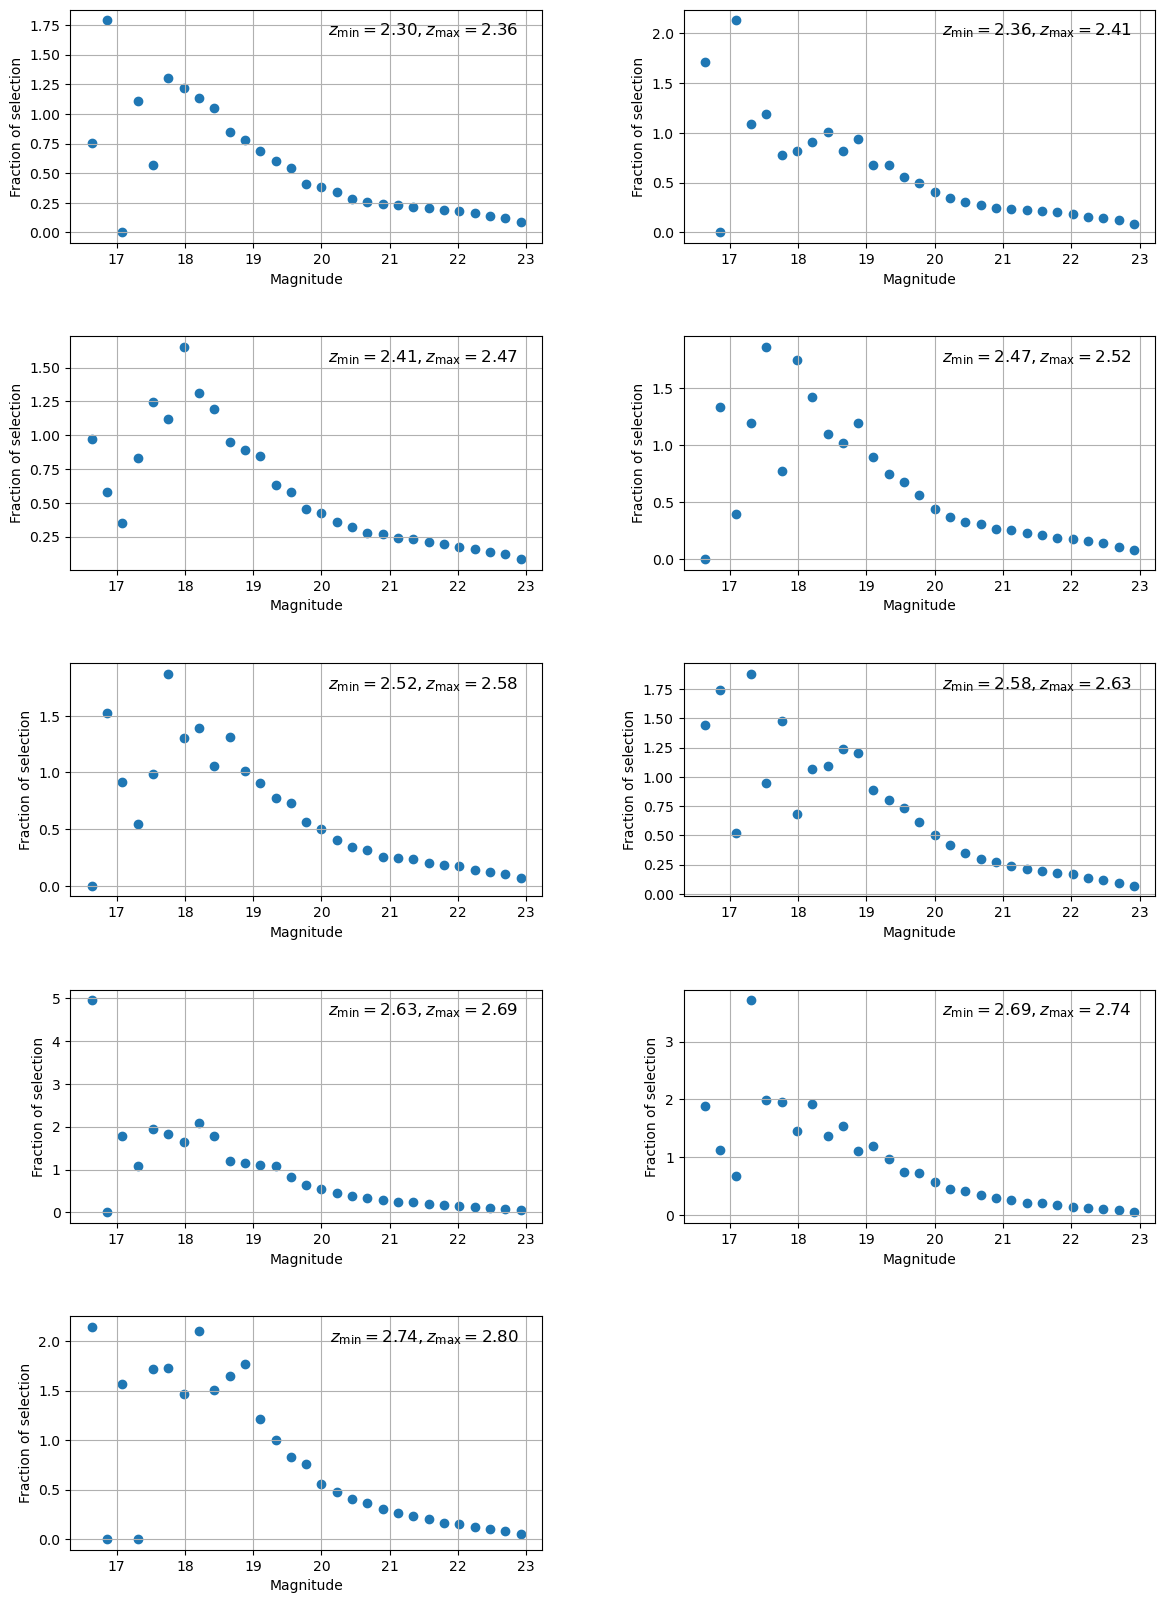

In [40]:
from matplotlib import gridspec
fig = plt.figure(figsize=(14, 20))
gs = gridspec.GridSpec(5, 2, hspace=0.4, wspace=0.3)

for i in range(0,9):
    mag_r_cens = 0.5*(mag_r_bins[1:]+mag_r_bins[:-1])
    new_mag_r_cens = 0.5*(mag_r_bins[1:]+mag_r_bins[:-1])
    ax = plt.subplot(gs[i])
    ax.scatter(mag_r_cens, phi_r[i,:]/phi_r_prediction[i,:],label='DESI')
    ax.grid()
    ax.set_xlabel('Magnitude')  # Label for the x-axis
    ax.set_ylabel('Fraction of selection')  # Label for the y-axis
    #ax.set_xlim([-32, -25])  # Adjust x-axis limits
    #ax.set_ylim([-9, -4])
    #ax.legend(loc='upper left')
    ax.text(0.95, 0.95, f'$z_{{\min}} = {z_bins[i]:.2f}, z_{{\max}} = {z_bins[i+1]:.2f}$', fontsize=12, ha='right', va='top', transform=ax.transAxes)

plt.show()

# QSO Distribution

In [41]:
# Specify the interval
interval = 0.2

# Calculate the number of bins
num_bins_mag1 = int((np.max(apr_mag_r) - np.min(apr_mag_r)) / interval) + 1

# Create the bins with the specified interval
mag_r_bins1 = np.linspace(np.min(apr_mag_r), np.max(apr_mag_r), num_bins_mag1)

# Calculate the number of bins
num_bins_z1 = int((np.max(z_desi) - np.min(z_desi)) / interval) + 1

# Create the bins with the specified interval
z_bins1 = np.linspace(np.min(z_desi), np.max(z_desi), num_bins_z1)

counts_r1,z_edges1,mag_r_edges1= np.histogram2d(z_desi, apr_mag_r, bins=[z_bins1, mag_r_bins1])

In [42]:
phi_r1 = np.zeros_like(counts_r1)
volumes1 = np.array([comoving_volume(z_edges1[i], z_edges1[i+1]) for i in range(len(z_edges1)-1)]) 
delta_m_r1 = np.diff(mag_r_bins1)
x=0
for i in range(len(z_bins1)-1):
    for j in range(len(mag_r_bins1)-1):
        phi_r1[i, j] = counts_r1[i, j] / (volumes1[i] * delta_m_r1[j])/0.16
        #print(phi_r1[i,j],counts_r1[i,j],volumes1[i],delta_m_r1[j])

In [43]:
phi_r_prediction1 = np.zeros((len(z_bins1)-1, len(mag_r_bins1)-1))

for i in range(len(z_bins1)-1):    
    for j in range(len(mag_r_bins1)-1):
        m_mid1 = 0.5 * (mag_r_bins1[j] + mag_r_bins1[j+1])
        phi_r_prediction1[i,j] = phi1(m_mid1,z_bins1[i],z_bins1[i+1])

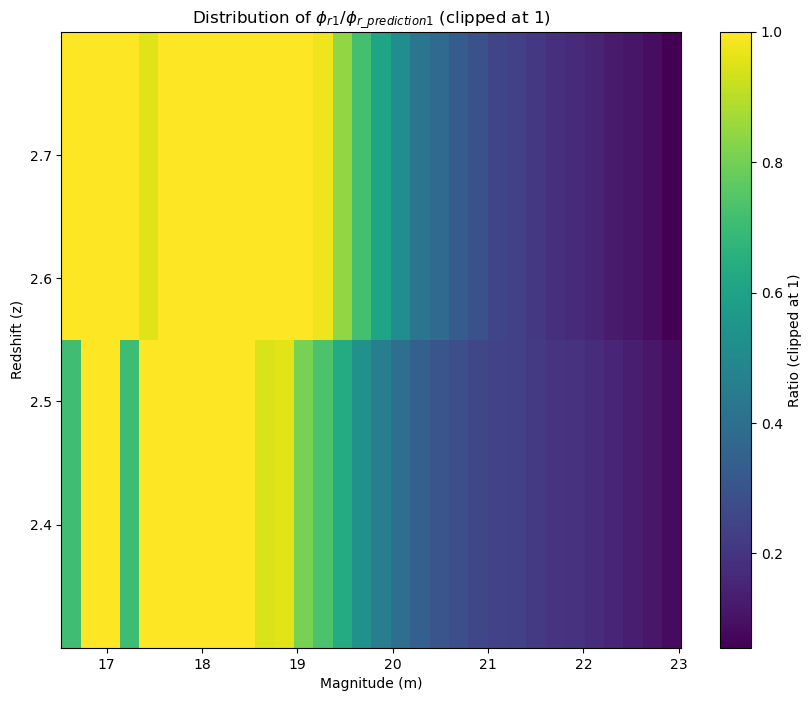

In [44]:
ratio = phi_r1 / phi_r_prediction1
ratio[ratio > 1] = 1
# Create a meshgrid for plotting
z_centers = (z_edges1[:-1] + z_edges1[1:]) / 2
mag_r_centers = (mag_r_edges1[:-1] + mag_r_edges1[1:]) / 2
M, Z = np.meshgrid(mag_r_centers, z_centers)  # Notice the order of M and Z

# Plot the distribution
plt.figure(figsize=(10, 8))
plt.pcolormesh(M, Z, ratio, cmap='viridis', shading='auto')
plt.colorbar(label='Ratio (clipped at 1)')
plt.xlabel('Magnitude (m)')
plt.ylabel('Redshift (z)')
plt.title('Distribution of $\phi_{r1} / \phi_{r\_prediction1}$ (clipped at 1)')
plt.show()